In [1]:
# hyperparams
SURFACE = 'Hard'

In [2]:
from tennis_new.fetch.get_joined import read_joined

jd = read_joined() 
assert jd['tourney_surface'].notnull().all()

/Users/siddhantjagadish/Documents/DataProjects/tennis_new/venv/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


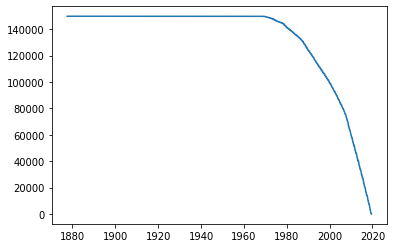

In [3]:
# How much grass data do we have over time?
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt

plt.plot(
    pd.to_datetime(jd['tourney_dates']),
    (jd['tourney_surface'] == SURFACE).sum() - (jd['tourney_surface'] == SURFACE).cumsum()
)

In [4]:
# 5000 for Grass, 10000 for the others...
from tennis_new.model.base import get_val_test_for_surface

TEST_NS = {
    'Hard': (10000, True),
    'Clay': (10000, True),
    'Grass': (5000, False)
}
test_n, atp_only = TEST_NS[SURFACE]

val_idx, test_idx = get_val_test_for_surface(jd, n=test_n, surface=SURFACE, atp_only=atp_only)

In [5]:
len(val_idx), len(test_idx)

(10001, 10002)

In [6]:
jd['tourney_dates'].iloc[[val_idx.min(), test_idx.min()]]

274664    2010.11.21
324182    2015.01.11
Name: tourney_dates, dtype: object

My validation set begins in June 2003 and my test begins in June 2012

In [7]:
def _eval_mod(mod):
    history_df = pd.DataFrame(mod.history)
    val_accuracy = (history_df.iloc[val_idx]['elo_match_prediction'] > 0.5).mean()
    test_accuracy = (history_df.iloc[test_idx]['elo_match_prediction'] > 0.5).mean()
    return {
        'val_accuracy': val_accuracy,
        'test_accuracy': test_accuracy
    }

In [8]:
# Universal ELO Model
from tennis_new.ml.elo import ELOModel

elo = ELOModel(winner_mod=True)
elo.fit_and_backfill(
    jd['winner_name'].tolist(),
    jd['loser_name'].tolist(),
    jd['match_id'].tolist()
)

In [9]:
_eval_mod(elo)

{'val_accuracy': 0.6939306069393061, 'test_accuracy': 0.6783643271345731}

In [10]:
# Get the tuned ELO
from tennis_new.model.config.elo.grass import GrassCourtELO
from tennis_new.model.config.elo.hardcourt import HardCourtELO
from tennis_new.model.config.elo.clay import ClayCourtELO 

repo_elo = {
    'Hard': HardCourtELO,
    'Grass': GrassCourtELO,
    'Clay': ClayCourtELO
}[SURFACE]

repo_mod_wrapper = repo_elo()
repo_mod_wrapper.fit(jd)
_eval_mod(repo_mod_wrapper.predictor)

{'val_accuracy': 0.6982301769823017, 'test_accuracy': 0.6813637272545491}

In [24]:
import numpy as np

np.random.uniform(size=100)

array([0.93787994, 0.88724233, 0.10013571, 0.28193592, 0.49591324,
       0.9079966 , 0.75663628, 0.42704827, 0.14832714, 0.26901705,
       0.41539299, 0.07255306, 0.51639051, 0.36968025, 0.10169596,
       0.07087909, 0.44007504, 0.54336447, 0.00474614, 0.24735005,
       0.11407979, 0.5957554 , 0.69192979, 0.83688028, 0.09390928,
       0.33728767, 0.42126355, 0.07879211, 0.15879847, 0.52480701,
       0.69669601, 0.45304432, 0.57334196, 0.46871742, 0.99506686,
       0.31873737, 0.33369823, 0.73552978, 0.17340477, 0.34189349,
       0.81919392, 0.25082053, 0.20607055, 0.5996312 , 0.85276077,
       0.85722557, 0.02045456, 0.23939413, 0.21277086, 0.3054137 ,
       0.26121424, 0.62867583, 0.78759871, 0.59685425, 0.70009228,
       0.12130979, 0.14094265, 0.9620438 , 0.75865926, 0.20750245,
       0.57670229, 0.32735432, 0.43640129, 0.8178096 , 0.67394443,
       0.07848966, 0.69043259, 0.8211081 , 0.22422531, 0.80685787,
       0.33236328, 0.1599124 , 0.25694453, 0.46861845, 0.75350

In [25]:
import numpy as np
from tennis_new.model.base import Weighter

weight_dict = repo_mod_wrapper.weighter.weight_dict

class EnsembleWeighter(Weighter):
    
    def __init__(self, base_weighter, keep_prop=0.7):
        self.base_weighter = base_weighter
        self.keep_prop = keep_prop 
        
    def required_columns(self):
        return self.base_weighter.required_columns
        
    def weight(self, df):
        base_weights = self.base_weighter.weight(df)
        return base_weights * (np.random.uniform(size=df.shape[0]) < self.keep_prop).astype(int)

In [26]:
# Get ensemble weighter
ens_weighter = EnsembleWeighter(repo_mod_wrapper.weighter)

In [29]:
(ens_weighter.weight(jd) == 0).mean()

0.2999301364178367

In [30]:
# Fit weak learners 
from tqdm import tqdm

N_WEAK_ELOS = 100

elos = []
for _ in tqdm(range(N_WEAK_ELOS)):
    weighter = EnsembleWeighter(repo_mod_wrapper.weighter)
    weights = weighter.weight(jd) 
    cur_elo = ELOModel(winner_mod=True)
    cur_elo.fit_and_backfill(
        jd['winner_name'].tolist(),
        jd['loser_name'].tolist(),
        jd['match_id'].tolist(),
        weights=weights
    )
    elos.append(cur_elo)

100%|██████████| 100/100 [04:29<00:00,  2.56s/it]


In [36]:
match_preds = [[v['elo_match_prediction'] for v in elo.history] for elo in elos]

In [39]:
all_preds = np.array(match_preds)

In [92]:
mean_preds = all_preds[:100,:].mean(axis=0)

In [93]:
mean_preds.shape

(380742,)

In [104]:
all_preds = np.array(match_preds)
history_df = pd.DataFrame(elos[0].history)
accs = []
for n_preds in tqdm(range(1, N_WEAK_ELOS + 1)):
    mean_preds = all_preds[:n_preds, :].mean(axis=0)
    history_df['elo_match_prediction'] = mean_preds  # Hack
    val_accuracy = (history_df.iloc[val_idx]['elo_match_prediction'] > 0.5).mean()
    test_accuracy = (history_df.iloc[test_idx]['elo_match_prediction'] > 0.5).mean()
    accs.append((val_accuracy, test_accuracy))

100%|██████████| 100/100 [00:02<00:00, 37.35it/s]


Text(0, 0.5, 'Centered Ensemble Accuracy')

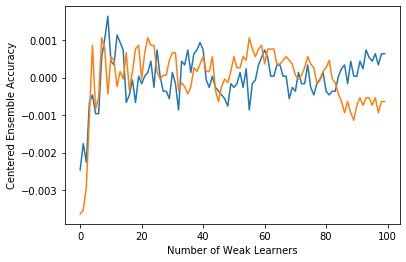

In [109]:
%matplotlib inline
from matplotlib import pyplot as plt

val_accs = np.array(list(zip(*accs))[0])
test_accs = np.array(list(zip(*accs))[1])

plt.plot(range(N_WEAK_ELOS), val_accs - val_accs.mean())
plt.plot(range(N_WEAK_ELOS), test_accs - test_accs.mean())
plt.xlabel("Number of Weak Learners")
plt.ylabel("Centered Ensemble Accuracy")

In [14]:
TOP_N = 10  # How many top weights to average?

tune_df = pd.DataFrame(out)
tune_df.sort_values('val_accuracy', ascending=False).head(TOP_N)
# Take average of top 10 for tuned weights
best_weights = dict(tune_df.sort_values('val_accuracy', ascending=False)[[
    'Clay', 'Carpet', 'Hard', 'Grass'
]].head(TOP_N).mean(axis=0))
best_weights

{'Clay': 0.39953124999999995,
 'Carpet': 0.6620312499999998,
 'Hard': 1.0,
 'Grass': 0.6926562499999999}

In [15]:
tune_df.sort_values('val_accuracy', ascending=False).head(TOP_N)

,Carpet,Clay,Grass,Hard,test_accuracy,val_accuracy
77,0.819531,0.469531,0.502344,1.0,0.680564,0.69983
53,0.857812,0.310937,0.967187,1.0,0.680464,0.69983
57,0.753906,0.491406,0.436719,1.0,0.680164,0.69973
18,0.496875,0.496875,0.409375,1.0,0.679564,0.69953
5,0.956250,0.343750,0.781250,1.0,0.680264,0.69943
6,0.628125,0.365625,0.890625,1.0,0.680664,0.69923
69,0.710156,0.360156,0.830469,1.0,0.679764,0.69893
54,0.578906,0.316406,0.611719,1.0,0.681264,0.69893
86,0.392969,0.327344,0.950781,1.0,0.679864,0.69883
82,0.425781,0.513281,0.546094,1.0,0.680064,0.69873


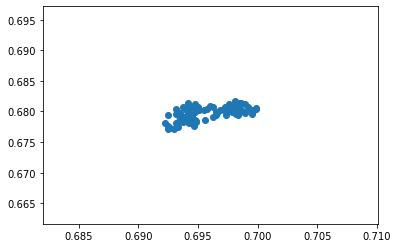

In [16]:
plt.scatter(tune_df['val_accuracy'], tune_df['test_accuracy'])

In [17]:
from scipy.stats import spearmanr

spearmanr(tune_df['val_accuracy'], tune_df['test_accuracy']).correlation

0.5796794590110046

Val performance and test performance are generally correlated...this is good!  Our results generalize!  We can get an extra half point of accuracy by just weighting the surfaces appropriately...We can take our optimal weights from above...

#### Let's Look at Best Model

In [18]:
weighter = SurfaceWeighter(best_weights)
_weights = weighter.weight(jd)
best_elo = ELOModel(winner_mod=True)
best_elo.fit_and_backfill(
    jd['winner_name'].tolist(),
    jd['loser_name'].tolist(),
    jd['match_id'].tolist(),
    weights=_weights
)

In [19]:
_eval_mod(best_elo)

{'val_accuracy': 0.6982301769823017, 'test_accuracy': 0.6813637272545491}

#### Hacky Check of Ser/Des of Models

In [20]:
from tennis_new.model.base import SurfaceWeighter, Surface
from tennis_new.model.config.elo.base import ELOBaseModel


class SurfaceELO(ELOBaseModel):

    @property
    def weighter(self):
        return SurfaceWeighter({
            Surface.hard.value: best_weights['Hard'],
            Surface.clay.value: best_weights['Clay'],
            Surface.grass.value: best_weights['Grass'],
            Surface.carpet.value: best_weights['Carpet'] 
        })

surface_from_repo = SurfaceELO()
surface_from_repo.fit(jd)

In [21]:
# Should get same evaluation...
_eval_mod(surface_from_repo.predictor)

{'val_accuracy': 0.6982301769823017, 'test_accuracy': 0.6813637272545491}

In [22]:
# models are the same
surface_from_repo.predictor.state_to_dict() == best_elo.state_to_dict()

True

In [23]:
# Great, reloading works!
reloaded = SurfaceELO(**surface_from_repo.state_to_dict())
reloaded.predictor.state_to_dict() == best_elo.state_to_dict()

True

#### Inspect Model

In [ ]:
# Get the last time each player played...
winner_deduped = jd.drop_duplicates('winner_name', keep='last').copy()
winner_deduped.rename(columns={'winner_name': 'player'}, inplace=True)

loser_deduped = jd.drop_duplicates('loser_name', keep='last').copy()
loser_deduped.rename(columns={'loser_name': 'player'}, inplace=True)

last_time_df = pd.merge(
    winner_deduped[['player', 'tourney_dates']],
    loser_deduped[['player', 'tourney_dates']],
    on='player',
    how='outer',
    suffixes=('_winner', '_loser')
)
last_time_df['tourney_dates_winner'] = pd.to_datetime(last_time_df['tourney_dates_winner'])
last_time_df['tourney_dates_loser'] = pd.to_datetime(last_time_df['tourney_dates_loser'])
last_time_df['max_date'] = last_time_df[['tourney_dates_winner', 'tourney_dates_loser']].max(axis=1)
last_play_dict = dict(zip(last_time_df['player'], last_time_df['max_date']))

In [ ]:
# Look at ELO Rankings
cur_elo_ratings = pd.DataFrame(
    best_elo.beta.items(),
    columns=['player', 'ELO']
)
cur_elo_ratings['max_date'] = cur_elo_ratings['player'].map(lambda x: last_play_dict[x])
ratings = cur_elo_ratings[cur_elo_ratings['max_date'] >= pd.to_datetime('2019.04.01')].sort_values('ELO', ascending=False).head(50)
ratings.index = range(1, ratings.shape[0] + 1)
ratings

#### Player Investigations

Some of these ratings don't quite make sense (they may be riding the high of their old selves...) Let's see what's going on with Andy Murray, for example

In [ ]:
best_history_df = pd.DataFrame(best_elo.history)
jd_with_history = pd.merge(jd, best_history_df, on='match_id')

In [ ]:
def plot_player_over_time(history_df, pid):
    rel = jd_with_history[
        (jd_with_history['p1_id'] == pid) | (jd_with_history['p2_id'] == pid)
    ]
    elos = rel[[
        'p1_id',
        'p2_id',
        'elo1',
        'elo2'
    ]].apply(
        lambda x: x['elo1'] if x['p1_id'] == pid else x['elo2'],
        axis=1
    )
    # plt.plot(range(len(elos)), elos)
    plt.plot(pd.to_datetime(rel['tourney_dates']), elos)
    plt.title("%s ELO for %s Over Time" % (SURFACE, pid))
    
plot_player_over_time(jd_with_history, 'Rafael Nadal')
plot_player_over_time(jd_with_history, 'Roger Federer')
# plt.xlim([pd.to_datetime('2018.01.01'), pd.to_datetime('2019.08.01')])
# plt.xticks(rotation=90)
# plt.ylim([2400, 2600])

In [ ]:
def examine_player(player, last_n=20, summarize_tourney=True):
    rel = jd_with_history[
        (jd_with_history['winner_name'] == player) |
        (jd_with_history['loser_name'] == player)
    ].copy()
    if summarize_tourney:
        rel.drop_duplicates('tourney_year_id', keep='last', inplace=True)
    return rel.tail(last_n)[[
        'tourney_dates',
        'tourney_title',
        'winner_name',
        'loser_name',
        'round',
        'round_order',
        'score',
        'elo1',
        'elo2',
        'elo_match_prediction',
        'tourney_surface'
    ]].sort_values(
        ['tourney_dates', 'round_order'], 
        ascending=[True, False]
    )

examine_player("Rafael Nadal", last_n=50, summarize_tourney=False)

Seems like Murray is well on his way down, but because we've built up such a history in the past, we're not able to adjust for his injury fast enough.  The Glicko model may be a better way of going about this?  Something is also mislabeled, because our data indicates that Andy Murray has played a match in the future (on Dec 31, 2019)

In [ ]:
def _find_player(p):
    _df = cur_elo_ratings[
        (cur_elo_ratings['player'].map(lambda x: p in x)) &
        (cur_elo_ratings['max_date'] > pd.to_datetime('2017.01.01'))
    ].sort_values('max_date', ascending=False)
    ret_player = _df['player'].iloc[0]
    if _df.shape[0] > 1:
        print("Found multiple players, returning %s..." % ret_player)
    return ret_player
        
def calculate_prob(p1, p2):
    p1_idx = _find_player(p1)
    p2_idx = _find_player(p2)
    prob = best_elo.predict(p1_idx, p2_idx)
    print(
        "{0} will defeat {1} with probability {2}, based on observing {3} matches for {0} and {4} matches for {1}".format(
            p1_idx,
            p2_idx,
            prob,
            best_elo.match_counts[p1_idx],
            best_elo.match_counts[p2_idx]
        )
    )
    print("{0} has ELO {1}".format(p1_idx, best_elo.beta[p1_idx]))
    print("{0} has ELO {1}".format(p2_idx, best_elo.beta[p2_idx]))

calculate_prob('Opelka', 'Evans')

This dude has played many more matches than this!  We will do much better if we can find them!  These matches are on the Challenger Tour, which is not represented in our current data

#### Aside, date writing

How do we read in dates appropriately with pandas csv reading?

In [ ]:
from datetime import datetime

dates = jd.apply(
    lambda x: datetime(
        month=int(x['tourney_month']),
        year=int(x['tourney_year']),
        day=int(x['tourney_day'])
    ),
    axis=1
)

In [ ]:
jd['date'] = pd.to_datetime(dates)

In [ ]:
jd.to_csv('./date_test.csv', index=False)

In [ ]:
q = pd.read_csv('./date_test.csv', parse_dates=['date'])